In [73]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.approximation import clique, max_clique
import networkx.algorithms.community as community

## Directed graph construction
- Nodes: students  
- Node attributes: 
    - School year 
    - Interest in politics
    - Affiliated political party
    - Healthy diet
    - Exercise  
- Edges: relationship  
- Edge weight: relationship type (close friend, friend, acquaitance)
- Edge attributes: call duration, number of sms exchanges

### Relationship and attribute data

In [29]:
# Relationship data
data = pd.read_csv("output/relationships.csv", index_col=0)
# Node and edge attributes
node_attr = pd.read_csv("output/subject_attributes.csv", index_col=0, na_values=["NaN", "nan-"])
edge_attr = pd.read_csv("output/calls_sms.csv", index_col=0)

In [30]:
data.head()

,id.A,id.B,survey.date,social_status
0,47,2,2008-09-09,CloseFriend
1,2,2,2008-09-09,CloseFriend
2,57,2,2008-09-09,CloseFriend
3,73,2,2008-09-09,Friend
4,55,2,2008-09-09,Friend


In [31]:
node_attr.head()

,user_id,year_school,interested_in_politics,preferred_party,survey.month,healthy_diet,exercise
0,1,GRT / Other,Slightly interested,Democrat,2008-09,Very healthy,7.0
1,1,GRT / Other,Somewhat interested,Independent,2008-10,Very healthy,5.0
2,1,GRT / Other,Somewhat interested,Independent,2008-11,NaN,NaN
3,1,GRT / Other,Somewhat interested,NaN,2008-12,Very healthy,4.0
4,1,GRT / Other,Slightly interested,NaN,2009-03,Very healthy,5.0


In [32]:
edge_attr.head()

,user.id,date,dest.id,duration,n_sms
0,1.0,2008-10,37,32783.0,2.0
1,1.0,2008-10,61,3460965.0,432.0
2,1.0,2008-11,61,100349.0,178.0
3,1.0,2008-12,37,6.0,NaN
4,1.0,2008-12,61,45715.0,300.0


In [33]:
# Convert survey date to datetime type and resample
data["survey.date"] = pd.to_datetime(data["survey.date"])
data["survey.date"] = data["survey.date"].dt.to_period('M')

node_attr = node_attr[node_attr["survey.month"].notnull()]
node_attr["survey.month"] = pd.to_datetime(node_attr["survey.month"])
node_attr["survey.month"] = node_attr["survey.month"].dt.to_period('M')

edge_attr["date"] = pd.to_datetime(edge_attr["date"])
edge_attr["date"] = edge_attr["date"].dt.to_period('M')

In [34]:
print(data["survey.date"].unique())
print(node_attr["survey.month"].unique())
print(edge_attr["date"].unique())

<PeriodArray>
['2008-09', '2008-10', '2008-12', '2009-03', '2009-04', '2009-05']
Length: 6, dtype: period[M]
<PeriodArray>
['2008-09', '2008-10', '2008-11', '2008-12', '2009-03', '2009-04', '2009-06']
Length: 7, dtype: period[M]
<PeriodArray>
['2008-10', '2008-11', '2008-12', '2009-01', '2008-09', '2009-02', '2009-03',
 '2009-04', '2009-05', '2009-06']
Length: 10, dtype: period[M]


## Construct NetworkX graph
Construct a directed and weighted graph for each survey date

In [35]:
# Generate vertex /node and edge attributes from survey data
def create_attr_dict(node_data, edge_data):
    node_attrs, edge_attrs = {}, {}
    columns = ["year_school", "interested_in_politics", "preferred_party", "healthy_diet", "exercise"]

    for i, row in node_data.iterrows():
        node_attrs[row["user_id"]] = {}
        
        for col in columns:
            if row[col] == row[col]: 
                node_attrs[row["user_id"]][col] = row[col]
             
    for i, row in edge_data.iterrows():
        edge_attrs[(int(row["user.id"]), int(row["dest.id"]))] = {}
        
        if row["duration"] == row["duration"]: 
            edge_attrs[(int(row["user.id"]), int(row["dest.id"]))]["call_time"] = row["duration"]
        if row["n_sms"] == row["n_sms"]: 
            edge_attrs[(int(row["user.id"]), int(row["dest.id"]))]["n_sms"] = row["n_sms"]

    return node_attrs, edge_attrs

In [36]:
def construct_graph(df, n_attr, e_attr):
    G = nx.DiGraph()
    weights = {"CloseFriend": 3, "Friend": 2, "Acquaintance": 1}
    
    for i, row in df.iterrows():
        # Exclude self loops
        if row["id.A"] != row["id.B"]:
            edge_weight = weights[row["social_status"]]
            G.add_edge(row['id.A'], row['id.B'], weight=edge_weight)
            
    nx.set_node_attributes(G, n_attr)
    nx.set_edge_attributes(G, e_attr)
    
    return G

In [37]:
graphs = {}

# Contruct a graph at each survey date
for date in data['survey.date'].unique():
    # Temporal relationship data
    df = data[data['survey.date'] == date]
    
    # Temporal subject attributes
    if str(date) == "2009-05":
        node_data = node_attr.loc[node_attr["survey.month"] == "2009-06"]
    else:
        node_data = node_attr.loc[node_attr["survey.month"] == date]
    edge_data = edge_attr.loc[edge_attr["date"] == date]
    
    n_attr, e_attr = create_attr_dict(node_data, edge_data)
    graphs[date] = {}
    graphs[date]["network"] = construct_graph(df, n_attr, e_attr)

### Compute network statistics

In [38]:
def compute_shortest_path(G):
    shortest_paths = []
    conn_nodes = 0
    combs = set(itertools.permutations(list(G.nodes), 2))
    
    for c in combs:
        try:
            shortest_paths.append(nx.shortest_path_length(G, c[0], c[1], weight="weight"))
            conn_nodes += 1
        except:
            continue
            
    avg_shortest_path = sum(shortest_paths) / conn_nodes
    diameter = max(shortest_paths)
    return avg_shortest_path, diameter

In [89]:
def compute_stats(G):
    stats = {}
    stats["n_nodes"] = len(G.nodes)
    stats["n_edges"] = len(G.edges)
    
    # Degree stats
    stats["avg_in_degree"] = sum([i[1] for i in G.in_degree]) / stats["n_nodes"]
    stats["avg_out_degree"] = sum([j[1] for j in G.out_degree]) / stats["n_nodes"]
    stats["avg_degree"] = sum([j[1] for j in G.degree]) / stats["n_nodes"]
    stats["max_in_degree"] = max([j[1] for j in G.in_degree])
    stats["max_out_degree"] = max([j[1] for j in G.out_degree])
    stats["max_degree"] = max([j[1] for j in G.degree])
    
    # Average shortest path and diameter
    avg_shortest_path, diameter = compute_shortest_path(G)
    stats["diameter"] = diameter
    stats["avg_shortest_path"] = avg_shortest_path

    stats["density"] = nx.density(G)
    stats["cl_coeff"] = nx.average_clustering(G)
    stats["n_triangles"] = sum([i for i in nx.triangles(G.to_undirected()).values()])
    stats["n_clique"] = nx.algorithms.clique.graph_clique_number(G.to_undirected())
    stats["max_clique_size"] = len(max_clique(G))
    
    # Reciprocity
    stats["reciprocity"] = nx.reciprocity(G)
    
    CF = nx.DiGraph(((u, v, e) for u,v,e in G.edges(data=True) if e["weight"] == 3))
    stats["close_fr_reciprocity"] = nx.reciprocity(CF)
    
    F = nx.DiGraph(((u, v, e) for u,v,e in G.edges(data=True) if e["weight"] == 2))
    stats["fr_reciprocity"] = nx.reciprocity(F)
    
    A = nx.DiGraph(((u, v, e) for u,v,e in G.edges(data=True) if e["weight"] == 1))
    stats["ac_reciprocity"] = nx.reciprocity(A)
    
    # Degree assortivity
    stats["deg_assortivity"] = nx.degree_assortativity_coefficient(G, weight="weight")

    return stats

In [90]:
for date in data['survey.date'].unique():
    G = graphs[date]["network"]
    graphs[date]["network_stats"] = compute_stats(G)
    
    print(date)
    for key in graphs[date]["network_stats"]:
        print("{}: {}".format(key, graphs[date]["network_stats"][key]))
    print("-"*20 + "\n")

2008-09
n_nodes: 75
n_edges: 2339
avg_in_degree: 31.186666666666667
avg_out_degree: 31.186666666666667
avg_degree: 62.373333333333335
max_in_degree: 48
max_out_degree: 74
max_degree: 122
diameter: 5
avg_shortest_path: 2.240388275599543
density: 0.42144144144144147
cl_coeff: 0.6640330574647452
n_triangles: 59160
n_clique: 30
max_clique_size: 15
reciprocity: 0.5865754595981189
close_fr_reciprocity: 0.5531914893617021
fr_reciprocity: 0.3958090803259604
ac_reciprocity: 0.22282608695652173
deg_assortivity: -0.15122846137634072
--------------------

2008-10
n_nodes: 78
n_edges: 1965
avg_in_degree: 25.192307692307693
avg_out_degree: 25.192307692307693
avg_degree: 50.38461538461539
max_in_degree: 41
max_out_degree: 75
max_degree: 115
diameter: 5
avg_shortest_path: 2.2906305947881442
density: 0.3271728271728272
cl_coeff: 0.6201757106048561
n_triangles: 41805
n_clique: 26
max_clique_size: 14
reciprocity: 0.5180661577608142
close_fr_reciprocity: 0.4358974358974359
fr_reciprocity: 0.31971580817051

### Changes in node and edge numbers - Densification Power Law

In [156]:
n_nodes = [graphs[date]["network_stats"]["n_nodes"] for date in data['survey.date'].unique()]
n_edges = [graphs[date]["network_stats"]["n_edges"] for date in data['survey.date'].unique()]
dia = [graphs[date]["network_stats"]["diameter"] for date in data['survey.date'].unique()]

print(n_nodes)
print(n_edges)

[75, 78, 82, 84, 84, 84]
[2339, 1965, 2219, 2096, 2146, 2141]


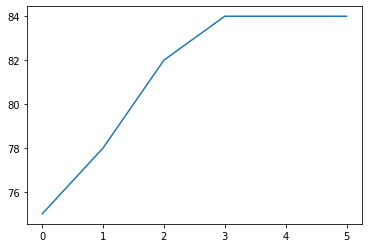

In [71]:
plt.plot(n_nodes)

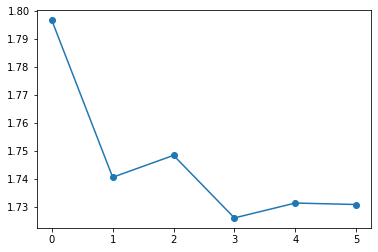

In [155]:
# Densification Power Law
plt.plot(np.log(n_edges) / np.log(n_nodes), marker="o")

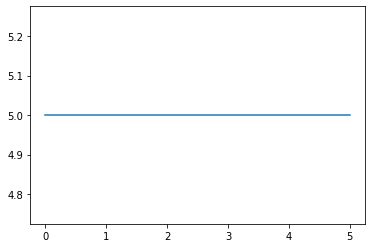

In [159]:
# Network diameter
plt.plot(dia)

### Average and maximum degrees over time

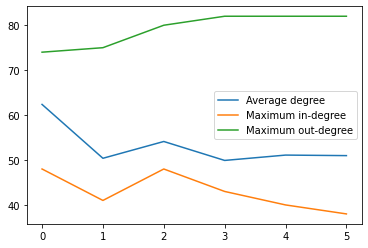

In [70]:
plt.plot([graphs[date]["network_stats"]["avg_degree"] for date in data['survey.date'].unique()])
plt.plot([graphs[date]["network_stats"]["max_in_degree"] for date in data['survey.date'].unique()])
plt.plot([graphs[date]["network_stats"]["max_out_degree"] for date in data['survey.date'].unique()])

plt.legend(["Average degree", "Maximum in-degree", "Maximum out-degree"])

### Cliques and triangles

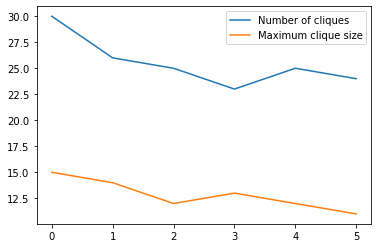

In [86]:
plt.plot([graphs[date]["network_stats"]["n_clique"] for date in data['survey.date'].unique()])
plt.plot([graphs[date]["network_stats"]["max_clique_size"] for date in data['survey.date'].unique()])

plt.legend(["Number of cliques", "Maximum clique size"])

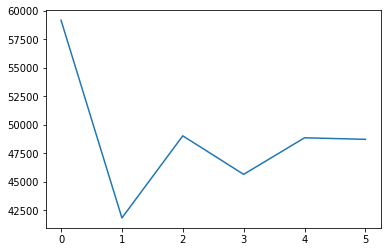

In [87]:
plt.plot([graphs[date]["network_stats"]["n_triangles"] for date in data['survey.date'].unique()])

### Clustering coefficient

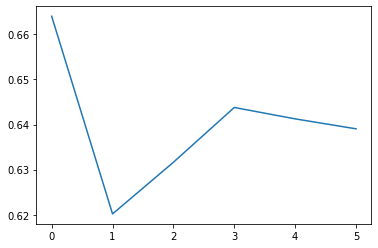

In [88]:
plt.plot([graphs[date]["network_stats"]["cl_coeff"] for date in data['survey.date'].unique()])

### Reciprocity

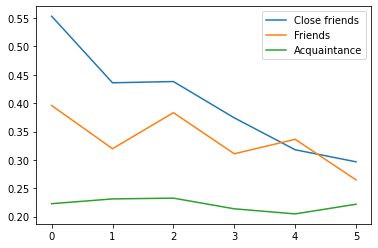

In [93]:
plt.plot([graphs[date]["network_stats"]["close_fr_reciprocity"] for date in data['survey.date'].unique()])
plt.plot([graphs[date]["network_stats"]["fr_reciprocity"] for date in data['survey.date'].unique()])
plt.plot([graphs[date]["network_stats"]["ac_reciprocity"] for date in data['survey.date'].unique()])

plt.legend(["Close friends", "Friends", "Acquaintance"])

## Centrality

In [102]:
def compute_centrality(G):
    # most influential vertex
    print("Degree centrality - most influential vertex")
    most_influential = nx.degree_centrality(G)
    for w in sorted(most_influential, key=most_influential.get, reverse=True)[:5]:
        print(w, most_influential[w])
    print("-"*20 + "\n")

    # most important vertex
    print("Eigenvector centrality - most important vertex")
    most_important = nx.eigenvector_centrality(G)
    for w in sorted(most_important, key=most_important.get, reverse=True)[:5]:
        print(w, most_important[w])
    print("-"*20 + "\n")
    
    # best connector
    print("In-betweenness centrality - best connector")
    best_connector = nx.betweenness_centrality(G)
    for w in sorted(best_connector, key=best_connector.get, reverse=True)[:5]:
        print(w, best_connector[w])
    print("-"*20 + "\n")
    
    return

In [103]:
for date in data['survey.date'].unique():
    G = graphs[date]["network"]
    
    # print date and top 3 central vertices
    print(date)
    compute_centrality(G)

2008-09
Degree centrality - most influential vertex
23 1.6486486486486487
28 1.5810810810810811
14 1.5810810810810811
65 1.5405405405405406
9 1.4864864864864866
--------------------

Eigenvector centrality - most important vertex
23 0.17539969647227077
44 0.16358630445547498
20 0.1618379451626123
14 0.15931232780735838
28 0.15705905389554542
--------------------

In-betweenness centrality - best connector
63 0.03999635274582023
23 0.039320993124347385
9 0.03931790469852702
28 0.03246051300584799
14 0.027806120721196117
--------------------

2008-10
Degree centrality - most influential vertex
23 1.4935064935064937
28 1.4285714285714286
14 1.4285714285714286
62 1.3506493506493507
65 1.3376623376623378
--------------------

Eigenvector centrality - most important vertex
23 0.1682918427808833
40 0.16245326290689974
46 0.15975422917354537
20 0.15912621242821995
18 0.15865187074930723
--------------------

In-betweenness centrality - best connector
23 0.050293386214448746
28 0.04689077781457

In [124]:
# Vertex 23 - number of friends and close frieends
print("Vertex 23")
print("# of close friends: {}".format(len([G[23][key]["weight"] for key in G[23] if G[23][key]["weight"]==3])))
print("# of friends: {}".format(len([G[23][key]["weight"] for key in G[23] if G[23][key]["weight"]==2])))
print("# of acquaintances: {}".format(len([G[23][key]["weight"] for key in G[23] if G[23][key]["weight"]==1])))
print(nx.get_node_attributes(G, "year_school")[23])

Vertex 23
# of close friends: 11
# of friends: 7
# of acquaintances: 63
Sophomore


## Assortativity
Assortativity measures the similarity of connections in the graph with respect to the given attribute.

In [128]:
columns = ["year_school", "interested_in_politics", "preferred_party", "healthy_diet", "exercise"]

for date in data['survey.date'].unique():
    G = graphs[date]["network"]
    
    # print date and attribute assortativity coefficient
    print(date)
    print("degree: {}".format(nx.degree_assortativity_coefficient(G, weight="weight")))
    for col in columns:
        print("{}: {}".format(col, nx.attribute_assortativity_coefficient(G, col)))
    print("-"*20 + "\n")

2008-09
degree: -0.15122846137634072
year_school: 0.05325706337477187
interested_in_politics: -0.015666947295636436
preferred_party: -0.009050552426683747
healthy_diet: -0.013070483836095497
exercise: -0.011589184945611916
--------------------

2008-10
degree: -0.16744533630274774
year_school: 0.037148522076438276
interested_in_politics: -0.020175565555216646
preferred_party: -0.003045597043518389
healthy_diet: -0.012994527135112713
exercise: -0.010896298641866612
--------------------

2008-12
degree: -0.16409825471820302
year_school: 0.051253426110306824
interested_in_politics: 0.0027787792978376247
preferred_party: nan
healthy_diet: -0.001287037860850688
exercise: -0.004470423471325493
--------------------

2009-03
degree: -0.18047199882364343
year_school: 0.03812442476696413
interested_in_politics: -0.006702181426638612
preferred_party: nan
healthy_diet: -0.0031000880560658793
exercise: -0.01613926421483358
--------------------

2009-04
degree: -0.13639878847268375
year_school: 0.03

## Community Detection

### Girvan - Newman Method
The Girvan - Newman Method uses edge betweenness centrality by default.

In [153]:
GN_n_comm = []
GN_max_comm_size = []

for date in data['survey.date'].unique():
    G = graphs[date]["network"]
    # Girvan–Newman method
    gn_communities = community.centrality.girvan_newman(G)
    
    # Print the communities and their size
    communities = tuple(len(sorted(c)) for c in next(gn_communities))
    print("{}: {}\n".format(date, communities))
    
    GN_n_comm.append(len(communities))
    GN_max_comm_size.append(max(communities))

2008-09: (74, 1)

2008-10: (77, 1)

2008-12: (81, 1)

2009-03: (83, 1)

2009-04: (83, 1)

2009-05: (83, 1)



### Clauset-Newman-Moore greedy modularity maximization

In [147]:
n_comm = []
max_comm_size = []

for date in data["survey.date"].unique():
    G = graphs[date]["network"]
    communities = tuple(len(c) for c in community.modularity_max.greedy_modularity_communities(
        G.to_undirected(), weight="weight"))
    
    # Print the community sizes
    print("{}: {}\n".format(date, communities))
    
    n_comm.append(len(communities))
    max_comm_size.append(max(communities))

2008-09: (19, 11, 6, 6, 4, 4, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2008-10: (16, 15, 9, 9, 6, 6, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2008-12: (18, 14, 10, 8, 7, 7, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2009-03: (14, 13, 10, 10, 9, 8, 6, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1)

2009-04: (24, 13, 11, 9, 5, 5, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2009-05: (19, 13, 10, 8, 7, 7, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1)



### Clauset-Newman-Moore method 
Modularity maximization with call times and sms exchanges as edge attributes

In [149]:
n_comm_2 = []
max_comm_size_2 = []

for date in data["survey.date"].unique():
    G = graphs[date]["network"]
    communities = tuple(len(c) for c in community.modularity_max.greedy_modularity_communities(
        G.to_undirected(), weight="call_time"))
    
    # Print the community sizes
    print("{}: {}\n".format(date, communities))

    n_comm_2.append(len(communities))
    max_comm_size_2.append(max(communities))

2008-09: (62, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2008-10: (16, 7, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2008-12: (21, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2009-03: (22, 6, 5, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2009-04: (39, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2009-05: (42, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)



In [150]:
n_comm_3 = []
max_comm_size_3 = []

for date in data["survey.date"].unique():
    G = graphs[date]["network"]
    communities = tuple(len(c) for c in community.modularity_max.greedy_modularity_communities(
        G.to_undirected(), weight="n_sms"))
    
    
    # Print the community sizes
    print("{}: {}\n".format(date, communities))
    n_comm_3.append(len(communities))
    max_comm_size_3.append(max(communities))

2008-09: (74, 1)

2008-10: (67, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1)

2008-12: (71, 3, 2, 1, 1, 1, 1, 1, 1)

2009-03: (77, 2, 1, 1, 1, 1, 1)

2009-04: (80, 2, 1, 1)

2009-05: (80, 2, 1, 1)



### Community plots

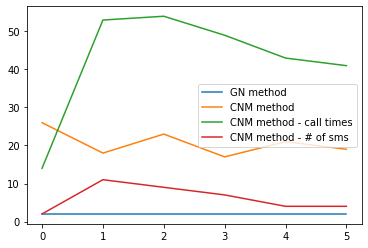

In [145]:
# Number of communities
plt.plot(GN_n_comm)
plt.plot(n_comm)
plt.plot(n_comm_2)
plt.plot(n_comm_3)

plt.legend(["GN method", "CNM method", "CNM method - call times", "CNM method - # of sms"])

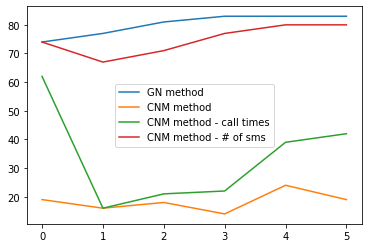

In [154]:
# Maximum community size
plt.plot(GN_max_comm_size)
plt.plot(max_comm_size)
plt.plot(max_comm_size_2)
plt.plot(max_comm_size_3)

plt.legend(["GN method", "CNM method", "CNM method - call times", "CNM method - # of sms"])